## Transformer and CNN 
EC523 PROJECT

In [1]:
!pip install einops

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: pip install --upgrade pip


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import random
from skimage.draw import disk
from skimage.measure import label, regionprops
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import os
from einops import rearrange



## Functions and Classes

In [3]:
'''
Functions
'''
class DiceLoss(nn.Module):
    def __init__(self, smooth=1e-6):
        super(DiceLoss, self).__init__()
        self.smooth = smooth

    def forward(self, pred, target):
        # Flatten tensors
        pred = pred.view(-1)
        target = target.view(-1)
        
        intersection = (pred * target).sum()
        dice_score = (2. * intersection + self.smooth) / (pred.sum() + target.sum() + self.smooth)
        return 1 - dice_score
    
def false_positive_loss(predicted_masks, ground_truth_masks):
    # Focus on ground truth masks that are empty
    empty_mask = (ground_truth_masks.sum(dim=(1, 2, 3)) == 0).float()  # Batch size dimension
    false_positive = (predicted_masks * empty_mask.unsqueeze(-1).unsqueeze(-1).unsqueeze(-1))
    return false_positive.mean()

def extra_region_penalty(predicted_masks, ground_truth_masks):
    non_overlap = predicted_masks * (1 - ground_truth_masks)  # Predicted regions outside GT
    return non_overlap.mean()

class CustomLoss(nn.Module):
    def __init__(self, base_loss, alpha=1.0, beta=1.0):
        super(CustomLoss, self).__init__()
        self.base_loss = base_loss
        self.alpha = alpha  # Weight for false positive penalty
        self.beta = beta    # Weight for extra region penalty

    def forward(self, predicted_masks, ground_truth_masks):
        base_loss = self.base_loss(predicted_masks, ground_truth_masks)
        fp_penalty = false_positive_loss(predicted_masks, ground_truth_masks)
        extra_penalty = extra_region_penalty(predicted_masks, ground_truth_masks)
        return base_loss + self.alpha * fp_penalty + self.beta * extra_penalty

class CircleDataset(Dataset):
    def __init__(self, num_samples=1000, image_size=(256, 256), max_circles=109):
        self.binary_masks, self.instance_masks = self.create_dataset(num_samples, image_size, max_circles)

    def __len__(self):
        return len(self.binary_masks)

    def __getitem__(self, idx):
        binary_mask = self.binary_masks[idx]
        instance_mask = self.instance_masks[idx]
        instance_mask = np.pad(instance_mask, ((0, 0), (0, 0), (0, 109 - instance_mask.shape[2])), constant_values=0)
        return torch.tensor(binary_mask, dtype=torch.float32).unsqueeze(0), torch.tensor(instance_mask, dtype=torch.float32)

    @staticmethod
    def create_dataset(num_samples=1000, image_size=(256, 256), max_circles=109):
        binary_masks = []
        instance_masks = []

        for _ in range(num_samples):
            num_circles = random.randint(1, max_circles)
            _, binary_mask, _, _ = generate_image_with_circles(image_size, num_circles)
            instances = generate_instance_masks(binary_mask)

            binary_masks.append(binary_mask)
            instance_stack = np.stack(instances, axis=-1) if instances else np.zeros((*image_size, 0))
            instance_masks.append(instance_stack)

        return np.array(binary_masks), instance_masks

def generate_image_with_circles(image_size=(256, 256), num_circles=109):
    """Generate an image with random circles and return the image and binary mask."""
    image = np.zeros(image_size, dtype=np.uint8)
    binary_mask = np.zeros(image_size, dtype=np.uint8)

    for _ in range(num_circles):
        radius = random.randint(4, 8)
        center = (
            random.randint(radius, image_size[0] - radius),
            random.randint(radius, image_size[1] - radius),
        )
        rr, cc = disk(center, radius, shape=image_size)
        binary_mask[rr, cc] = 1

    return image, binary_mask, [], []

def generate_instance_masks(binary_mask):
    """Generate instance masks from a binary mask."""
    labeled_mask = label(binary_mask)
    instance_masks = []
    for region in regionprops(labeled_mask):
        instance_mask = labeled_mask == region.label
        instance_masks.append(instance_mask)
    return instance_masks

def visualize_results(image, binary_mask, instance_masks):
    """Visualize the image, binary mask, and instance masks."""
    fig, axes = plt.subplots(1, 2 + len(instance_masks), figsize=(15, 5))
    
    axes[0].imshow(image, cmap='gray')
    axes[0].set_title("Original Image")
    axes[0].axis("off")

    axes[1].imshow(binary_mask, cmap='gray')
    axes[1].set_title("Binary Mask")
    axes[1].axis("off")

    for i, instance_mask in enumerate(instance_masks):
        axes[2 + i].imshow(instance_mask, cmap='gray')
        axes[2 + i].set_title(f"Instance Mask {i + 1}")
        axes[2 + i].axis("off")

    plt.tight_layout()
    plt.show()




def get_instance_masks(image, plot = None): # Plot Masks - plot = 1
    Masks = []
    
    cell_count, cell_colors = get_cell_count(image)
    
    # Create mask for each Cell: 
    for cell in range(cell_count):

        # Cell Color
        color = cell_colors[cell]
        
        if color != 0:
            # Find Pixels
            cell_indices = (image.flatten() == color)

            # Form mask of cell in a 256x256 image with black background (all other pixels in image are colored 0)
            mask = np.zeros((image.shape[0]**2, 1), dtype=np.uint8)        
            mask[cell_indices] = 1

            #Here I do not believe that we need to keep thier original color. This gets tricky with classifcation because we go from 0 1 classification to essential regression down to the precision of N class aprx. 1/109 max prec.

            mask = mask.reshape((image.shape[0], image.shape[0]))

            if plot == 1:
                # Visualize the mask
                plt.figure()
                plt.imshow(mask, cmap="gray")
                plt.title(f"Mask for Cell {cell + 1}")
                plt.axis("off")
            Masks.append(mask)
            
    if len(Masks) < 109:
        for k in range(109-len(Masks)):
            mask = np.zeros((image.shape[0]**2, 1), dtype=np.uint8)  
            mask = mask.reshape((image.shape[0], image.shape[0]))
            Masks.append(mask)
    
    if len(Masks) > 109:
        return

    if plot == 1:
        plt.show()

    return Masks

def get_cell_count(image): 

    # Masked Image (256 x 256) 
    unique_colors = np.unique(image)
    cell_colors = unique_colors[unique_colors != 0]  # Exclude background (color 0)

    # Cell Count
    cell_count = len(cell_colors)    
    
    return cell_count, cell_colors


def load_and_downsample_images(folder_path):
    tiff_files = [f for f in os.listdir(folder_path) if f.endswith('.tif') or f.endswith('.tiff')]
    original_images = []  # Store original images

    for file_name in tiff_files:
        file_path = os.path.join(folder_path, file_name)
        image = np.array(Image.open(file_path))#.convert("L")  # Convert to grayscale
        
        # Ensure the image is 256x256, or resize if necessary
        if image.shape != (256, 256):
            # Split the image into 4 quarters
            top_left = image[:256, :256]  # Top-left quarter
            top_right = image[:256, 256:]  # Top-right quarter
            bottom_left = image[256:, :256]  # Bottom-left quarter
            bottom_right = image[256:, 256:]  # Bottom-right quarter

            # Stack the quarters to form a (4, 128, 128) array
            quarters_image = np.stack([top_left, top_right, bottom_left, bottom_right])
            # Append the quarters image to the list
            for i in range(4):
                original_images.append(quarters_image[i])
            
        else: 
            original_images.append(np.array(image))  # Store the original image

    return np.stack(original_images).astype(np.float32)   #, np.stack(downsampled_images)  # Return both original and downsampled #No longer need downsample

class create_dataset_form(Dataset):
    def __init__(self, binary_masks, instance_masks):
        """
        Initializes the dataset.

        Args:
            binary_masks (np.ndarray or torch.Tensor): Binary masks, shape (num_samples, 1, H, W).
            instance_masks (np.ndarray or torch.Tensor): Instance masks, shape (num_samples, H, W, max_circles).
        """
        self.binary_masks = torch.tensor(binary_masks, dtype=torch.float32) if not isinstance(binary_masks, torch.Tensor) else binary_masks
        self.instance_masks = torch.tensor(instance_masks, dtype=torch.float32) if not isinstance(instance_masks, torch.Tensor) else instance_masks

    def __len__(self):
        """Returns the number of samples in the dataset."""
        return self.binary_masks.shape[0]

    def __getitem__(self, idx):
        """
        Returns the binary and instance masks for a given index.

        Args:
            idx (int): Index of the sample.

        Returns:
            tuple: (binary_mask, instance_mask), both as torch.Tensor.
        """
        binary_mask = self.binary_masks[idx]  # Shape: (1, H, W)
        instance_mask = self.instance_masks[idx]  # Shape: (H, W, max_circles)
        return binary_mask, instance_mask

    
# Function to visualize predictions
def visualize_predictions(images, masks, outputs, num_examples=4):
    """
    Visualize a few examples of the input images, ground truth masks, and model predictions.

    Args:
        images (torch.Tensor): Input images.
        masks (torch.Tensor): Ground truth masks.
        outputs (torch.Tensor): Model predictions.
        num_examples (int): Number of examples to visualize.
    """
    # Convert tensors to CPU for visualization
    images = images[:num_examples].cpu().numpy()
    masks = masks[:num_examples].cpu().numpy()
    outputs = torch.sigmoid(outputs[:num_examples]).cpu().numpy()  # Apply sigmoid to get probabilities

    # Plot the results
    fig, axes = plt.subplots(num_examples, 3, figsize=(12, num_examples * 4))
    for i in range(num_examples):
        # Input image
        axes[i, 0].imshow(images[i, 0], cmap="gray")
        axes[i, 0].set_title("Input Image")
        axes[i, 0].axis("off")

        # Ground truth mask
        axes[i, 1].imshow(masks[i, 0], cmap="gray")
        axes[i, 1].set_title("Ground Truth Mask")
        axes[i, 1].axis("off")

        # Model prediction
        axes[i, 2].imshow(outputs[i, 0], cmap="gray")
        axes[i, 2].set_title("Model Prediction")
        axes[i, 2].axis("off")

    plt.tight_layout()
    plt.show()



## Load Images

**Training Images**

In [8]:
'''
Create Train DataLoader
'''
# Load original and downsampled brightfield images
brightfield_folder = '/projectnb/ec523kb/projects/teams_Fall_2024/Team_2/bacteria_counting/Data/2b/DeepBacs_Data_Segmentation_Staph_Aureus_dataset/brightfield_dataset/train/patches/brightfield'
original_brightfield = load_and_downsample_images(brightfield_folder)

# Load original and downsampled masks
masks_folder = '/projectnb/ec523kb/projects/teams_Fall_2024/Team_2/bacteria_counting/Data/2b/DeepBacs_Data_Segmentation_Staph_Aureus_dataset/brightfield_dataset/train/patches/masks'
original_masks = load_and_downsample_images(masks_folder)

print(original_masks.shape)
Y2 = []
for k in range(len(original_masks)):
    instance_Y2 = get_instance_masks(original_masks[k])
    # print((np.array(instance_Y2).shape))
    Y2.append(instance_Y2)

Y2 = np.array(Y2)
original_brightfield = np.expand_dims(original_brightfield, axis=1)

Y2 = np.transpose(Y2, (0,2,3,1))

print(f'Train Masks:', Y2.shape)
print(f'Train Images:', original_brightfield.shape)

# Create Train Loader
train_dataset = create_dataset_form(original_brightfield,Y2)
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)

(28, 256, 256)
Train Masks: (28, 256, 256, 109)
Train Images: (28, 1, 256, 256)


**Testing Images**

In [9]:
'''
Create Test DataLoader
'''
# Load original and downsampled brightfield images
brightfield_folder = '/projectnb/ec523kb/projects/teams_Fall_2024/Team_2/bacteria_counting/Data/2b/DeepBacs_Data_Segmentation_Staph_Aureus_dataset/brightfield_dataset/test/brightfield'
original_brightfield = load_and_downsample_images(brightfield_folder)

# Load original and downsampled masks
masks_folder = '/projectnb/ec523kb/projects/teams_Fall_2024/Team_2/bacteria_counting/Data/2b/DeepBacs_Data_Segmentation_Staph_Aureus_dataset/brightfield_dataset/test/masks'
original_masks = load_and_downsample_images(masks_folder)

print(original_masks.shape)
Y2 = []
for k in range(len(original_masks)):
    instance_Y2 = get_instance_masks(original_masks[k])
    # print((np.array(instance_Y2).shape))
    Y2.append(instance_Y2)

Y2 = np.array(Y2)
original_brightfield = np.expand_dims(original_brightfield, axis=1)

Y2 = np.transpose(Y2, (0,2,3,1))

print(f'Test Masks:', Y2.shape)
print(f'Test Images:', original_brightfield.shape)

# Create Train Loader
test_dataset = create_dataset_form(original_brightfield,Y2)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=True)

(20, 256, 256)
Test Masks: (20, 256, 256, 109)
Test Images: (20, 1, 256, 256)


## MODEL

**CNN CLASS**

In [10]:
class CNNFeatureExtractor(nn.Module):
    def __init__(self, output_channels=64):
        super(CNNFeatureExtractor, self).__init__()
        self.cnn = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),  # First Conv Layer
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # Downsample by 2
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),  # Second Conv Layer
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # Downsample by 2
            nn.Conv2d(64, output_channels, kernel_size=3, stride=1, padding=1),  # Final Conv Layer
            nn.BatchNorm2d(output_channels),
            nn.ReLU()
        )
    
    def forward(self, x):
        return self.cnn(x)

**TRANSFORMER CLASS**

In [11]:
class SimpleTransformer(nn.Module):
    def __init__(self, img_size, patch_size, embed_dim, num_heads, num_layers, cnn_extractor, num_instances):
        """
        Args:
            img_size (int): Size of the input image (assumes square, e.g., 256).
            patch_size (int): Size of each patch (e.g., 16).
            embed_dim (int): Embedding dimension for the Transformer.
            num_heads (int): Number of attention heads.
            num_layers (int): Number of Transformer layers.
            cnn_extractor (nn.Module): CNN backbone to extract features.
            num_instances (int): Number of output masks (e.g., 109).
        """
        super(SimpleTransformer, self).__init__()
        self.cnn_extractor = cnn_extractor
        self.patch_size = patch_size
        self.embed_dim = embed_dim
        self.num_instances = num_instances

        # Transformer layers
        self.position_embedding = None
        self.transformer = nn.Transformer(embed_dim, num_heads, num_layers, num_layers)
        
        # Prediction head
        self.head = nn.Linear(embed_dim, patch_size * patch_size * num_instances)

        # Upsampling layer to match the target size
        self.upsample = nn.Upsample(size=(img_size, img_size), mode='bilinear', align_corners=False)

    def forward(self, x):
        # Extract features using CNN backbone
        x = self.cnn_extractor(x)  # Output shape: (B, C, H, W)
        B, C, H, W = x.shape

        # Flatten spatial dimensions for the transformer
        x = rearrange(x, 'b c h w -> b (h w) c')  # Shape: (B, num_patches, C)

        num_patches = x.size(1)

        # Add position embedding
        if self.position_embedding is None or self.position_embedding.size(1) != num_patches:
            self.position_embedding = nn.Parameter(torch.randn(1, num_patches, self.embed_dim).to(x.device))

        x = x + self.position_embedding  # Add positional encoding
        x = self.transformer(x, x)  # Apply transformer

        # Convert transformer output to patch-level predictions
        h_patches = w_patches = int(num_patches ** 0.5)  # Assuming square patch layout
        x = self.head(x)  # Shape: (B, num_patches, patch_size * patch_size * num_instances)

        # Rearrange back to image dimensions
        x = rearrange(x, 
                      'b (h_patches w_patches) (p1 p2 num_instances) -> b num_instances (h_patches p1) (w_patches p2)',
                      h_patches=h_patches, w_patches=w_patches, p1=self.patch_size, p2=self.patch_size, 
                      num_instances=self.num_instances)

        # Upsample to match the full resolution
        x = self.upsample(x)  # Final shape: (B, num_masks, img_size, img_size)
        # Rearrange to desired format: (batch_size, img_size, img_size, num_masks)
        x = x.permute(0, 2, 3, 1)  # Final shape: (B, 256, 256, 109)

        return x


## Training

In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Initialize the CNN
cnn_extractor = CNNFeatureExtractor(output_channels=64)

# Initialize the Transformer with CNN as backbone
model = SimpleTransformer(img_size=256, patch_size=8, embed_dim=64, num_heads=4, num_layers=4, cnn_extractor=cnn_extractor, num_instances = 109).to(device)

# Train the model
optimizer = optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.BCEWithLogitsLoss()
num_epochs = 6000
training_loss = []

# Save Model File
best_loss = float('inf')  
best_model_path = "best_model_TransformerCNN_trial.pth"  ## edit path


for epoch in range(num_epochs):
    model.train()
    total_loss = 0.0
    
    for images, masks in train_loader:  # Assuming dataloader includes all data
        images, masks = images.to(device), masks.to(device)
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, masks)
        
        # Backpropagation and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
    
    # Calculate and print average loss for the epoch
    avg_loss = total_loss / len(train_loader)
    training_loss.append(avg_loss)
    
    if avg_loss < best_loss:
        best_loss = avg_loss
        torch.save(model.state_dict(), best_model_path)
        
    if (epoch + 1) % 100 == 0:
        print()
        print(f"Epoch {epoch + 1}, Loss: {avg_loss:.4f}")
    
    # Print loss every 100 epochs (adjusted here since num_epochs is small)
    if (epoch + 1) % 100 == 0:  
        with torch.no_grad():
            # Visualizing the binary mask for the current batch
            binary_mask = images[0].squeeze(0).cpu().numpy()
            instance_masks = masks[0].cpu().numpy()
            predicted_masks = outputs[0].cpu().numpy()

            fig, axes = plt.subplots(2, 11 + 1, figsize=(18, 6))

            # Binary Mask
            axes[0, 0].imshow(binary_mask, cmap='gray')
            axes[0, 0].set_title("Binary Mask")
            axes[0, 0].axis("off")

            # Ground Truth Masks
            for i in range(11):
                axes[0, i + 1].imshow(instance_masks[..., i], cmap='gray')
                axes[0, i + 1].set_title(f"GT Mask {i+1}")
                axes[0, i + 1].axis("off")

            # Predicted Masks
            for i in range(11):
                axes[1, i + 1].imshow(predicted_masks[..., i], cmap='gray')
                axes[1, i + 1].set_title(f"Pred Mask {i+1}")
                axes[1, i + 1].axis("off")

            # Sum of Predicted Masks
            predicted_sum = np.sum(predicted_masks, axis=-1)
            axes[1, 0].imshow(predicted_sum, cmap='gray')
            axes[1, 0].set_title("Sum of Predicted Masks")
            axes[1, 0].axis("off")

            # Layout adjustment
            plt.tight_layout()
            plt.show()
                
    # Store all Images, Masks, Outputs at the last epoch
    if epoch == num_epochs - 1:
        model.eval()
        all_images = []
        all_masks = []
        all_outputs = []
        with torch.no_grad():
            for images, masks in train_loader:
                images, masks = images.to(device), masks.to(device)
                outputs = model(images)
                all_images.append(images.cpu())
                all_masks.append(masks.cpu())
                all_outputs.append(outputs.cpu())
        
        # Concatenate and save as tensors
        all_images = torch.cat(all_images, dim=0)
        all_masks = torch.cat(all_masks, dim=0)
        all_outputs = torch.cat(all_outputs, dim=0)

KeyboardInterrupt: 

(0.0, 2190.0)

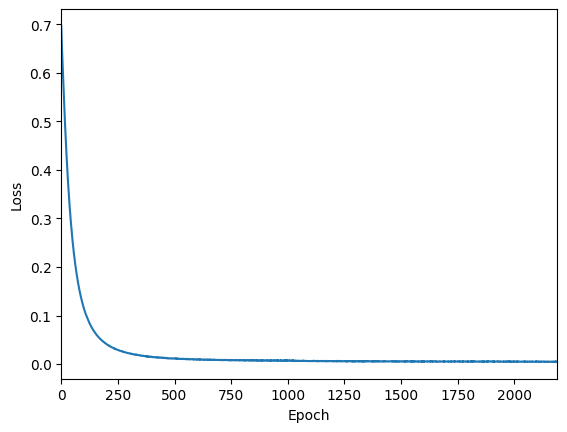

In [29]:
## Training Performance: 

plt.plot(range(2190), training_loss)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.xlim((0, 2190))

## TESTING

Loss: 0.003029263267914454


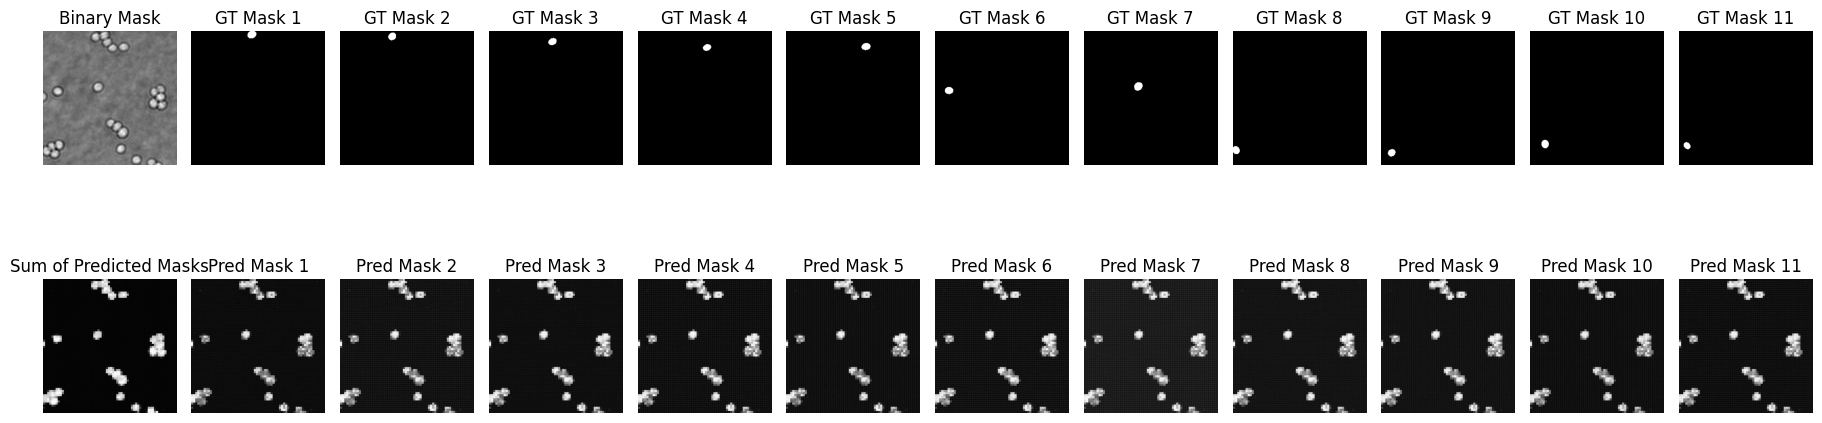

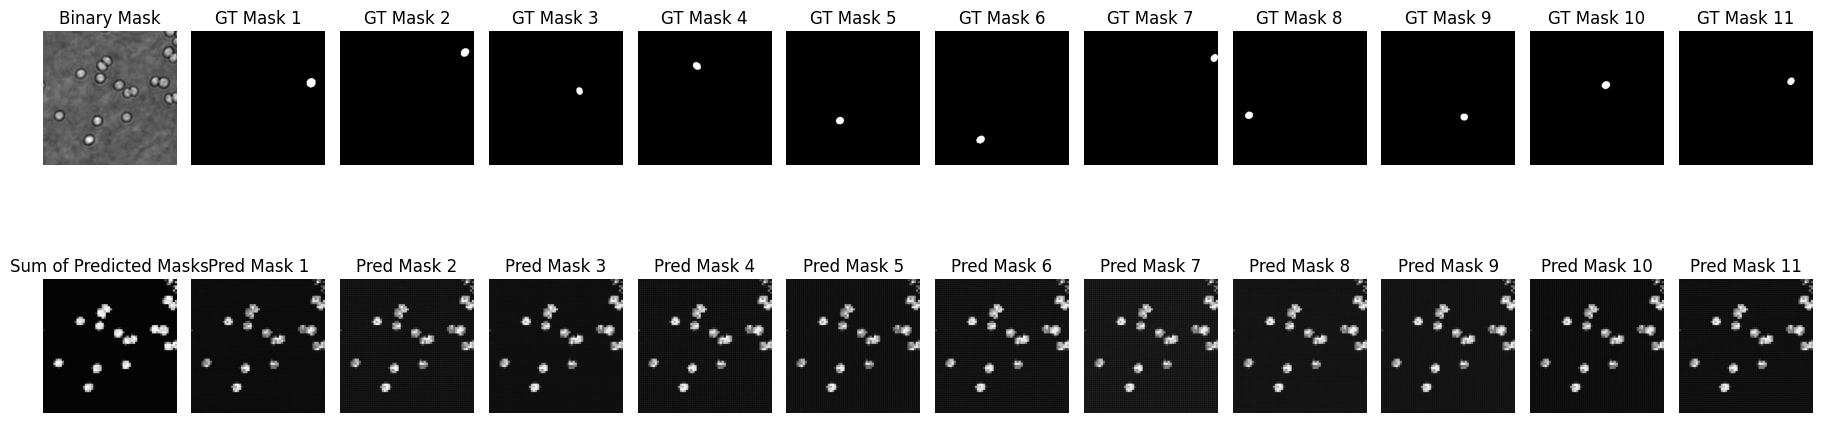

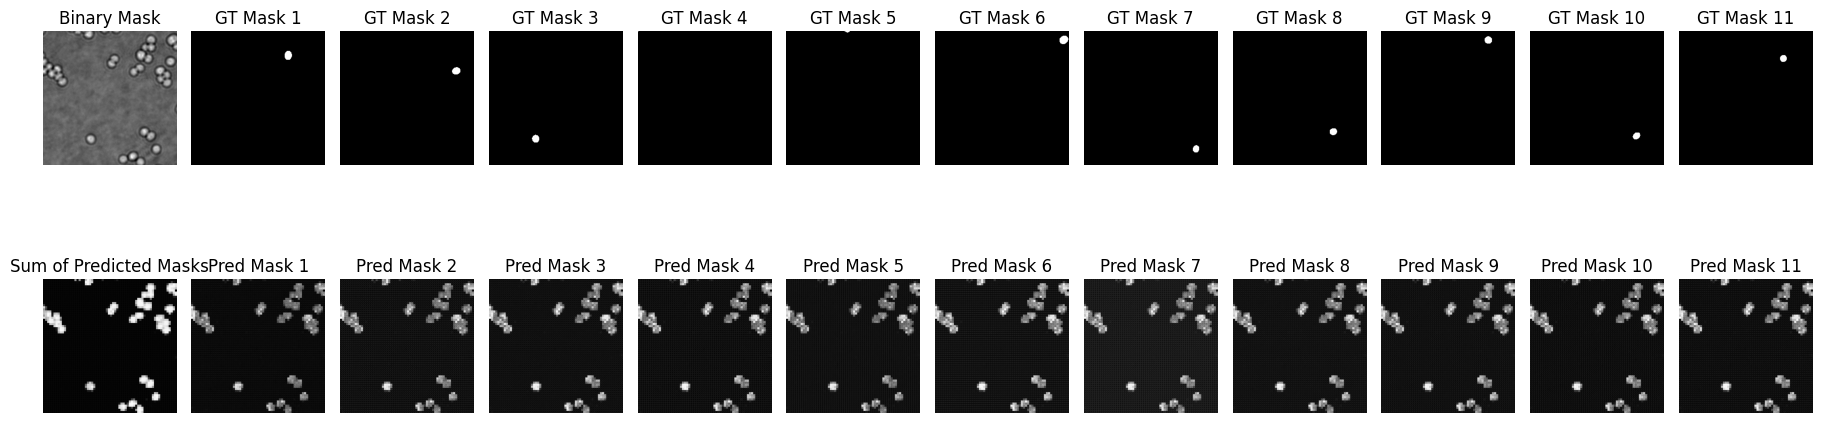

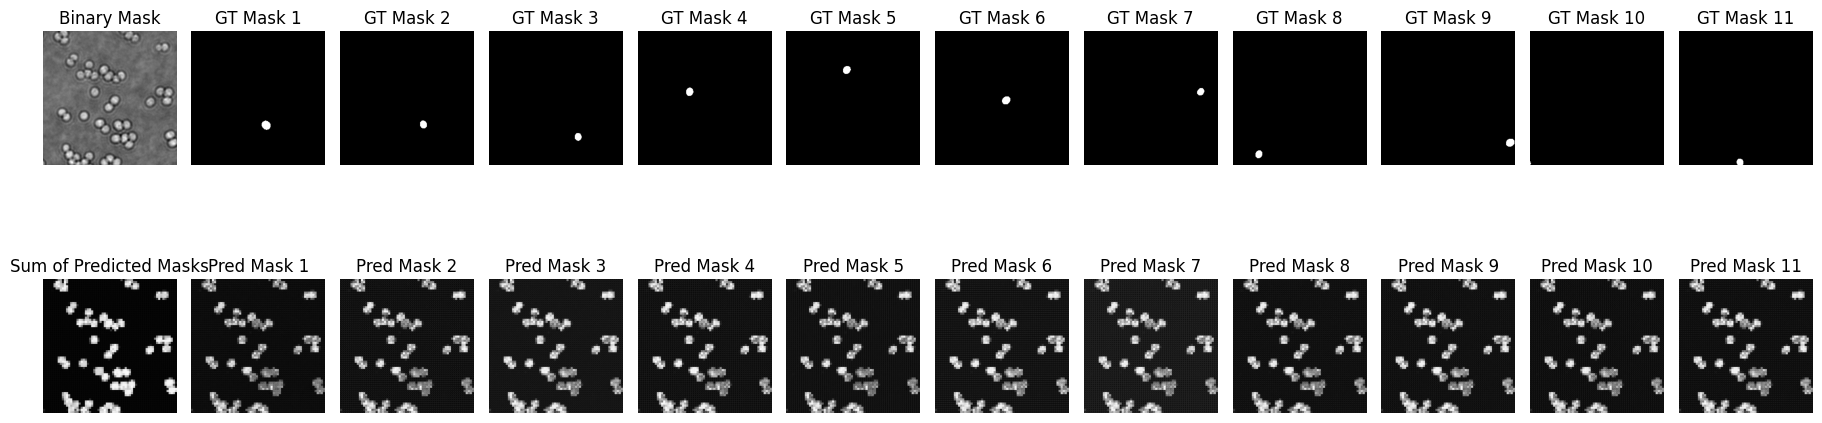

In [13]:
# Test Model 
model.load_state_dict(torch.load(f'best_model_TransformerCNN_6000_Omar.pth'))
model.eval()
with torch.no_grad():
    for images, masks in test_loader:  # Assuming dataloader includes all data
        images, masks = images.to(device), masks.to(device)
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, masks)
        
        # Backpropagation and optimization
        total_loss += loss.item()
        
    # Calculate and print average loss for the epoch
    avg_loss = total_loss / len(test_loader)
    print('Loss:', avg_loss)
    
    for i in range(len(images)):
        # Visualizing the binary mask for the current batch
        binary_mask = images[i].squeeze(0).cpu().numpy()
        instance_masks = masks[i].cpu().numpy()
        predicted_masks = outputs[i].cpu().numpy()

        fig, axes = plt.subplots(2, 11 + 1, figsize=(18, 6))

        # Binary Mask
        axes[0, 0].imshow(binary_mask, cmap='gray')
        axes[0, 0].set_title("Binary Mask")
        axes[0, 0].axis("off")

        # Ground Truth Masks
        for i in range(11):
            axes[0, i + 1].imshow(instance_masks[..., i], cmap='gray')
            axes[0, i + 1].set_title(f"GT Mask {i+1}")
            axes[0, i + 1].axis("off")

        # Predicted Masks
        for i in range(11):
            axes[1, i + 1].imshow(predicted_masks[..., i], cmap='gray')
            axes[1, i + 1].set_title(f"Pred Mask {i+1}")
            axes[1, i + 1].axis("off")

        # Sum of Predicted Masks
        predicted_sum = np.sum(predicted_masks, axis=-1)
        axes[1, 0].imshow(predicted_sum, cmap='gray')
        axes[1, 0].set_title("Sum of Predicted Masks")
        axes[1, 0].axis("off")

        # Layout adjustment
        plt.tight_layout()
        plt.show()